In [1]:
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from src.load_covid19 import load_clean_covid19

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.inspection import permutation_importance

from tensorflow import keras
from tensorflow.keras import layers

Laden der Rohdaten

In [2]:
#Wir importieren die Rohdaten als Dataframe. 

current_dir = os.getcwd()
file_path = os.path.join(os.path.dirname(current_dir), "data", "raw", "covid19-dataset", "Covid Data.csv")
df = pd.read_csv(file_path)

Definition benötigter Funktionen

In [3]:
#Wir definieren eine Funktion, die kompakt alle relevanten Evaluationsmetriken berechnet. 

def get_scores(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    return acc, f1, prec, rec, mcc

In [4]:
#Wir definieren eine Funktion, um die Roc-Kurven und deren AUC-Werte für verschiedene Klassifikatoren vergleichen zu können. 

def roc_auc(models, test_y):
    plt.figure()
    for model in models:
        y_probs = model.predict_proba(test_x)[:, 1]
        fpr, tpr, thresholds = roc_curve(test_y, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.axis('square')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    plt.show()

In [5]:
#Die Funktion unique_analyse dient dazu, die Anzahl der unique-Datenpunkte zu bestimmen. Zusätzlich werden
#die Anzahl der unique-Datenpunkte mit gemischten Labels, die Anzahl der dazugehörigen Zeilen, deren Prozentsatz
#sowie die Anzahl der unique-Datenpunkte mit "gut" gemischten Labels (d.h. eines der beiden Labels macht jeweils mehr als 5% bzw.
#weniger als 95% aller Labels der zu einem unique-Datenpunkt gehörigen Zeilen aus), die Anzahl der entsprechenden Zeilen sowie 
#deren Prozentsatz bestimmt.

def unique_analyse(df,target):
    df_red = df.drop(columns=[target])
    cols = list(df_red.columns)
    df_temp = df_red.groupby(cols)
    idx=df_temp.groups.keys()
    print(f'Anzahl der unique-Datenpunkte: {len(idx)}'+'\n')
    mixed_unique_points = 0
    really_mixed_unique_points = 0
    number_rows_mixed = 0
    number_rows_really_mixed = 0
    for i in idx:
        j=df_temp.groups[i]
        df_unique=df.loc[j]
        number_rows_per_point = len(df_unique)
        number_positives_per_point = df_unique[target].sum()
        if (number_positives_per_point!=number_rows_per_point)and(number_positives_per_point!=0):
            mixed_unique_points +=1
            number_rows_mixed += len(df_unique)
            if (number_positives_per_point/number_rows_per_point<0.95)and(number_positives_per_point/number_rows_per_point>0.05):
                really_mixed_unique_points += 1
                number_rows_really_mixed += len(df_unique)
    print(f'Anzahl der unique-Datenpunkte mit gemischten Labels: {mixed_unique_points}')
    print(f'Anzahl der Zeilen zu Datenpunkten mit gemischten Labels: {number_rows_mixed}')
    print(f'Dies sind {round(100*number_rows_mixed/len(df),2)}% aller Zeilen.'+'\n')
    print(f'Anzahl der unique-Datenpunkte mit "gut" gemischten Labels: {really_mixed_unique_points}')
    print(f'Anzahl der Reihen zu Datenpunkten mit "gut" gemischten Labels: {number_rows_really_mixed}')
    print(f'Dies sind {round(100*number_rows_really_mixed/len(df),2)}% aller Zeilen.')

Vorverarbeitung des Datensatzes

In [6]:
#Wir fügen zuerst ein neues Attribut hinzu, das angibt, ob die Person gestorben ist oder nicht. 
#Die Verschlüsselung erfolgt konsistent mit den anderen Attributen (2 für "nein", 1 für "ja").
#Das Todesdatum wird als Attribut verworfen. 

df['DIED'] = [2 if i=='9999-99-99' else 1 for i in df.DATE_DIED]
df=df.drop(columns='DATE_DIED')

In [7]:
#Eine Analyse der Missing Values zeigt, dass diese vor allem in den Spalten "PREGNANT", "ICU" und "INTUBED" vorkommen.
#Das Attribut "PREGNANT" wird bei allen männlichen Patienten auf 2 gesetzt.
#Das Attribut "PATIENT_TYPE" gibt an, ob die Person hospitalisiert war oder nicht. Bei allen Patienten ohne
#Krankenhausaufenthalt kann das Attribut "ICU" auf 2 gesetzt werden, da keiner dieser Patienten folglich auf
#einer Intensivstation behandelt wurde. 
#Dieselbe Vorgehensweise wenden wir auf das Attribut "INTUBED" an. Dazu gehen wir von der Grundannahme aus, dass
#ein Anschluss an ein Beatmungsgerät im Rahmen eines Klinikaufenthaltes erfolgt. Etwaige Fälle von Heimintubation 
#vernachlässigen wir dabei. 

df.loc[df.SEX==2,'PREGNANT']=2
df.loc[df.PATIENT_TYPE==1,'ICU']=2
df.loc[df.PATIENT_TYPE==1,'INTUBED']=2

In [8]:
#Für die anderen fehlenden Werte können keine sinnvollen Aussagen getroffen werden. Da sie nur einen sehr kleinen
#Anteil des gesamten Datensatzes ausmachen (2.76%), verwerfen wir sie. 

for col in df.columns.drop('AGE'):
    for i in [97,98, 99]:
        df[col]=df[col].replace(i , np.nan)

df=df.dropna()

In [9]:
#Wir normieren das Attribut "AGE" auf das Intervall [0,1] und bilden die "2" bei den binären Attributen auf die "0" ab
df['AGE'] = (df['AGE'] - df['AGE'].min()) / (df['AGE'].max() - df['AGE'].min())

for col in df.columns.drop(['AGE','CLASIFFICATION_FINAL', 'MEDICAL_UNIT', 'PATIENT_TYPE', 'USMER']):
    re_map_dict = {2:0}
    df[col]=df[col].replace(re_map_dict)

In [10]:
#Wir fügen dem Dataframe ein neues Attribut "At_RISK" hinzu, das die ODER-Verknüpfung der drei Zielvariablen darstellt. Dieses 
#neue Attribut codiert das Risiko eines schweren COVID-Verlaufs und wird als Zielvariable dienen. 

df=df.astype('float32')
df['AT_RISK'] = df['DIED']+df['INTUBED']+df['ICU']
df.AT_RISK = df.AT_RISK.apply(lambda x: 1 if x > 0 else 0) 
target='AT_RISK'

In [11]:
#Wir verwerfen die beiden Attribute 'MEDICAL_UNIT' und 'USMER', die Art und Stufe der behandelnden medizinischen Einrichtung
#codieren, da deren genaue Bedeutung aufgrund der spärlichen Annotation unklar bleibt. Außerdem werden die drei Attribute
#'DIED', 'INTUBED' und 'ICU' verworfen, da diese bereits in die Zielvariable eingegangen sind. 

discarded_features = ['MEDICAL_UNIT', 'USMER','DIED','ICU','INTUBED']
df = df.drop(discarded_features, axis=1)

In [12]:
#Wir testen die Attribute auf Korrelation mit der Zielvariablen testen und verwerfen alle Attribute,
#deren Korrelation absolut unter einem vorgegebenen Schwellwert von 0.04 liegen.

threshold=0.04
selected_features=df.corr()[target][abs(df.corr()[target])>threshold].index
not_selected_features=df.corr()[target][abs(df.corr()[target])<threshold]
print(not_selected_features)
df=df[selected_features]

PREGNANT   -0.017308
ASTHMA     -0.017983
TOBACCO     0.005573
Name: AT_RISK, dtype: float64


In [13]:
#Wir analysieren den aufbereiteten Datensatz auf unique-Datenpunkte.

unique_analyse(df,target)

Anzahl der unique-Datenpunkte: 54359

Anzahl der unique-Datenpunkte mit gemischten Labels: 12097
Anzahl der Zeilen zu Datenpunkten mit gemischten Labels: 601799
Dies sind 59.02% aller Zeilen.

Anzahl der unique-Datenpunkte mit "gut" gemischten Labels: 11181
Anzahl der Reihen zu Datenpunkten mit "gut" gemischten Labels: 176338
Dies sind 17.29% aller Zeilen.


Vorbereitung für die Anwendung der Machine-Learning-Verfahren

In [14]:
#Wir teilen den Datensatz in Trainings- und Testdatensatz im Verhältnis 80 zu 20 auf. 

test_size=0.2
train, test = train_test_split(df, test_size=test_size, shuffle=True)

train_y = train[target]
train_x = train.drop(columns=['AT_RISK'])

test_y = test[target]
test_x = test.drop(columns=['AT_RISK'])

In [15]:
#Da die Werte der Zielvariablen sehr unbalanciert sind (siehe exploratische Analyse), wenden wir ein balanciertes
#zufallsgesteuertes Undersampling an. Mit diesem stark reduzierten Datensatz weisen der Support-Vektor-Maschinen-
#Klassifikator und der K-Nächste-Nachbarn-Klassifikator eine akzeptable Laufzeit auf. 

train_xus, train_yus = RandomUnderSampler(sampling_strategy={0:10000,1:10000}).fit_resample(train_x, train_y)
test_xus, test_yus = RandomUnderSampler(sampling_strategy={0:10000,1:10000}).fit_resample(test_x, test_y)

#Alternativ ist auch ein SMOTE-Oversampling - eventuell in Kombination mit einem anschließenden Undersampling - denkbar, 
#um ein balanciertes Trainingsset zu erreichen. Allerdings stoßen die Support-Vektor-Maschine und insbesondere der KNN
#hier immer noch an ihre Grenzen. 

"""
sm = SMOTE(sampling_strategy=0.5)
train_x, train_y = sm.fit_resample(train_x, train_y)
under = RandomUnderSampler(sampling_strategy=0.5)
train_x, train_y = under.fit_resample(train_x,train_y)
"""
train_x=train_xus
train_y=train_yus
test_x=test_xus
test_y=test_yus

Definition von Hilfsfunktionen für die Verwendung der Machine-Learning-Verfahren

In [16]:
#Wir definieren eine Funktion zur übersichtlichen Ausgabe der Evaluationsmetriken.

def print_measures(clf, acc, f1, prec, rec, mcc, *args):
    if args:
        name = type(clf).__name__
        for arg in args:
            name = name + " " + arg
        
    else: 
        name = type(clf).__name__
    print(f"Klassifikator: "+name+"\n")
    print(f'Accuracy: {acc}')
    print(f'F1: {f1}')
    print(f'Precision: {prec}')
    print(f'Recall: {rec}')
    print(f'MCC: {mcc}'+"\n")
    


In [17]:
#Wir definieren eine Funktion, die die Ergebnisse der Feature-Importance-Analyse übersichtlich ausgibt. 

def analyze_feature_importance(train_x, train_y, classifier):
            perm_importance = permutation_importance(clf, train_x, train_y, n_repeats=10)
            sorted_idx = perm_importance.importances_mean.argsort()
            fig = plt.figure(figsize=(12, 6))
            plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
            plt.yticks(range(len(sorted_idx)), np.array(test_x.columns)[sorted_idx])
            plt.title('Permutation Importance')

In [18]:
#Wir definieren eine Funktion, die eine einheitliche Anwendung der verschiedenen Klassifikatoren erlaubt. 

def apply_classifier(train_x, train_y, classifier, verbose=True, *args):
    classifier.fit(train_x, train_y)
    if isinstance(classifier, DecisionTreeClassifier)and(classifier.get_depth()<4):
        feature_names = list(train_x.columns)
        plt.figure(figsize=(20,10)) # Größe der Grafik anpassen
        tree.plot_tree(classifier, filled=True,feature_names=feature_names,class_names=['died','not_died'])
        plt.show()
    y_pred = classifier.predict(test_x)
    acc, f1, prec, rec, mcc = get_scores(test_y, y_pred)
    if verbose: 
        print_measures(classifier, acc, f1, prec, rec, mcc, *args)
    return acc, f1, prec, rec, mcc


Anwendung von ML-Verfahren: Naive Bayes

In [19]:
#Wir wenden zunächst drei verschiedene Varianten eines Naive-Bayes-Klassifikators an: 

for clf in [GaussianNB(),MultinomialNB(),BernoulliNB()]:
    apply_classifier(train_x, train_y, clf)

Klassifikator: GaussianNB

Accuracy: 0.87305
F1: 0.8722387158456197
Precision: 0.877848678213309
Recall: 0.8667
MCC: 0.7461601765140002

Klassifikator: MultinomialNB

Accuracy: 0.84845
F1: 0.8484121030257564
Precision: 0.848624312156078
Recall: 0.8482
MCC: 0.6969000871125163

Klassifikator: BernoulliNB

Accuracy: 0.8329
F1: 0.8291934989267096
Precision: 0.8480033451808489
Recall: 0.8112
MCC: 0.6664279243132052



Anwendung von ML-Verfahren: Support-Vektor-Maschine

In [20]:
#Wir wenden Support Vector Maschinen mit drei verschiedenen Kerneltypen an:
f1_measures = []

for kernel in ["linear", "poly", "rbf"]:
    clf = SVC(kernel=kernel, degree=8, class_weight='balanced')
    f1 = apply_classifier(train_xus, train_yus, clf, kernel)[1]
    f1_measures.append(f1)
    

Klassifikator: SVC

Accuracy: 0.9044
F1: 0.906127258444619
Precision: 0.8900462962962963
Recall: 0.9228
MCC: 0.8093482115263633

Klassifikator: SVC

Accuracy: 0.8892
F1: 0.8895644373567229
Precision: 0.8866481223922114
Recall: 0.8925
MCC: 0.7784169541058926

Klassifikator: SVC

Accuracy: 0.916
F1: 0.9192152336987882
Precision: 0.885327899221934
Recall: 0.9558
MCC: 0.8346484349070344



Anwendung von ML-Verfahren: KNN

In [22]:
#Als nächstes probieren wir KNN aus:
ks = [5,7,9]

accs = []
f1s = []
precs = []
recs = []
mccs = []

for k in ks:
    clf = KNeighborsClassifier(n_neighbors=k)
    # Scale the features using StandardScaler
    # scaler = StandardScaler()
    # test_x_std = scaler.fit_transform(validation_x)
    # X_test = scaler.transform(X_test)
    acc, f1, prec, rec, mcc = apply_classifier(train_xus, train_yus, clf, True, str(k))
    accs.append(acc)
    f1s.append(f1)
    precs.append(prec)
    recs.append(rec)
    mccs.append(mcc)

Klassifikator: KNeighborsClassifier 5

Accuracy: 0.8978
F1: 0.8989219661754525
Precision: 0.8891606339268245
Recall: 0.9089
MCC: 0.795796124248384

Klassifikator: KNeighborsClassifier 7

Accuracy: 0.907
F1: 0.908957415565345
Precision: 0.8902205177372963
Recall: 0.9285
MCC: 0.8147535881996079

Klassifikator: KNeighborsClassifier 9

Accuracy: 0.9157
F1: 0.9183060374067255
Precision: 0.8907689415303629
Recall: 0.9476
MCC: 0.8330972651310653



Anwendung von ML-Verfahren: Logistische Regression

In [24]:
#Danach wenden wir die logistische Regression an:

clf = LogisticRegression(max_iter=500)
apply_classifier(train_x, train_y, clf);


Klassifikator: LogisticRegression

Accuracy: 0.9102
F1: 0.9114660356896381
Precision: 0.8987944779311686
Recall: 0.9245
MCC: 0.8207357331682715



Anwendung von ML-Verfahren: Entscheidungsbaum

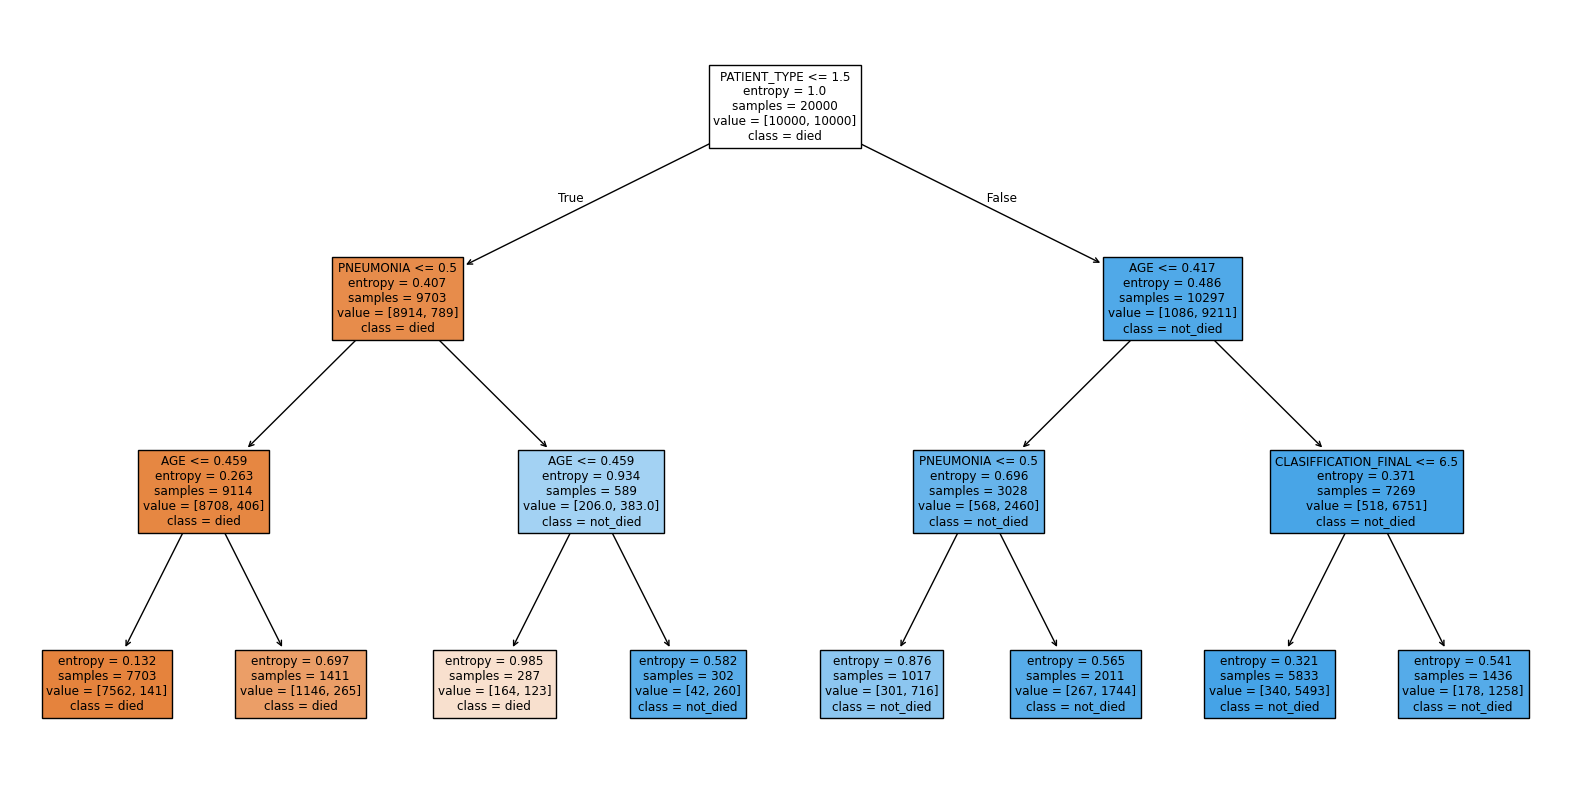

Klassifikator: DecisionTreeClassifier 3 entropy best

Accuracy: 0.91515
F1: 0.9179360704095942
Precision: 0.8887536286169117
Recall: 0.9491
MCC: 0.8322206555260584



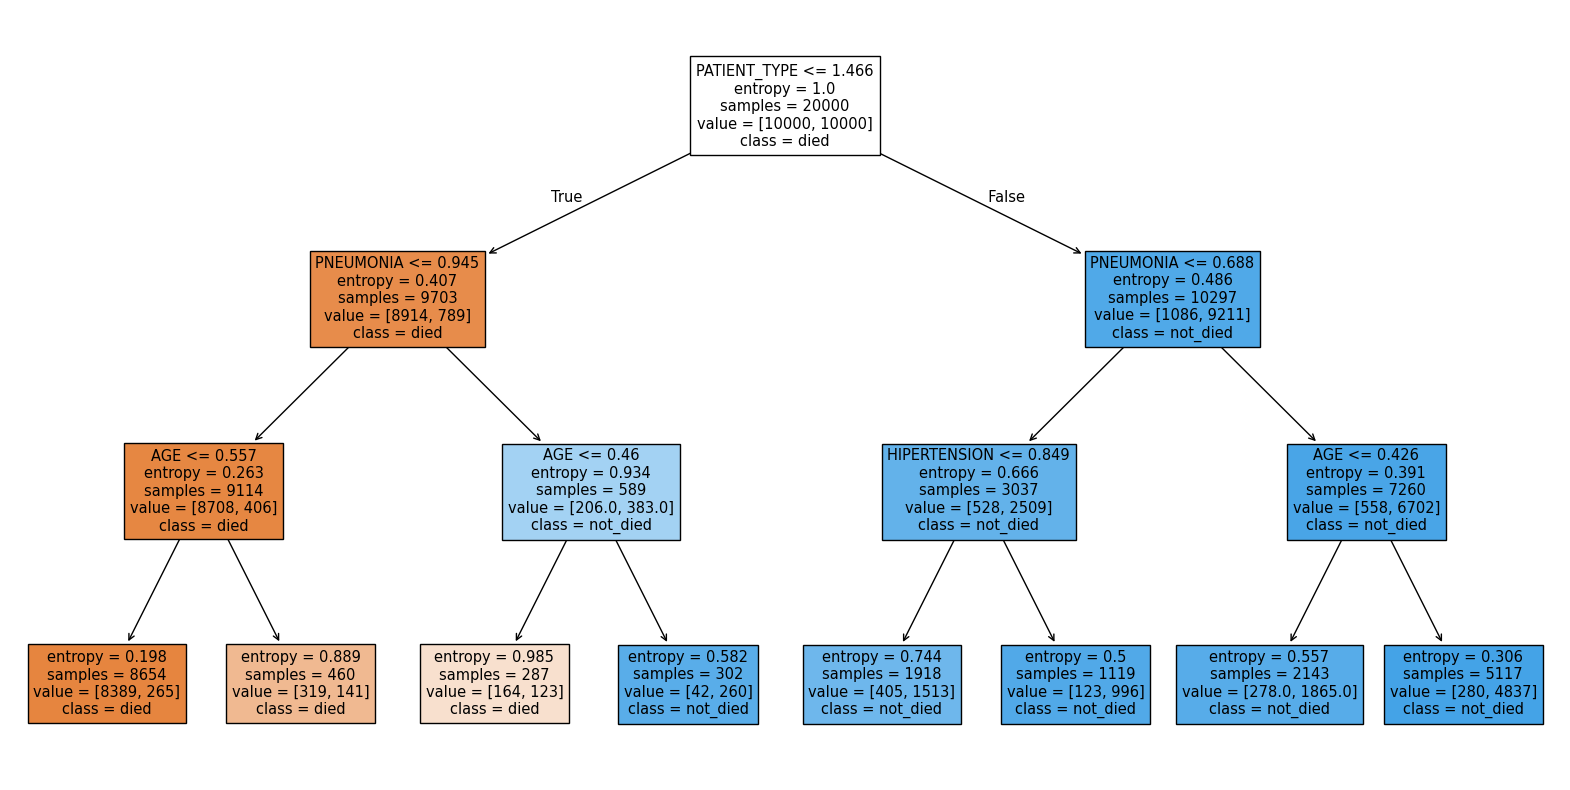

Klassifikator: DecisionTreeClassifier 3 entropy random

Accuracy: 0.91515
F1: 0.9179360704095942
Precision: 0.8887536286169117
Recall: 0.9491
MCC: 0.8322206555260584



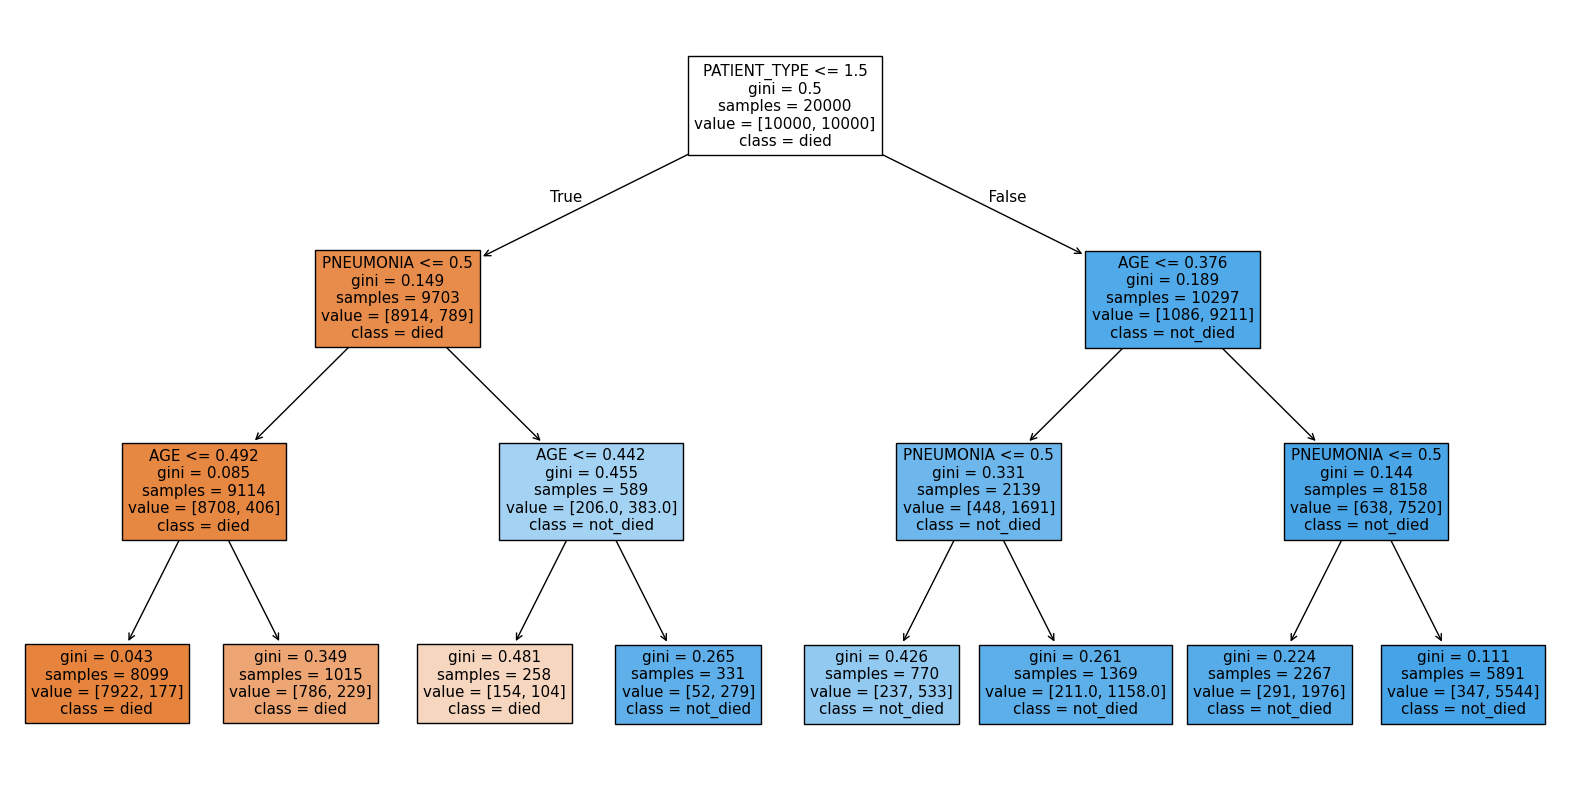

Klassifikator: DecisionTreeClassifier 3 gini best

Accuracy: 0.9162
F1: 0.9190494590417311
Precision: 0.8888266068759342
Recall: 0.9514
MCC: 0.8344704531011339



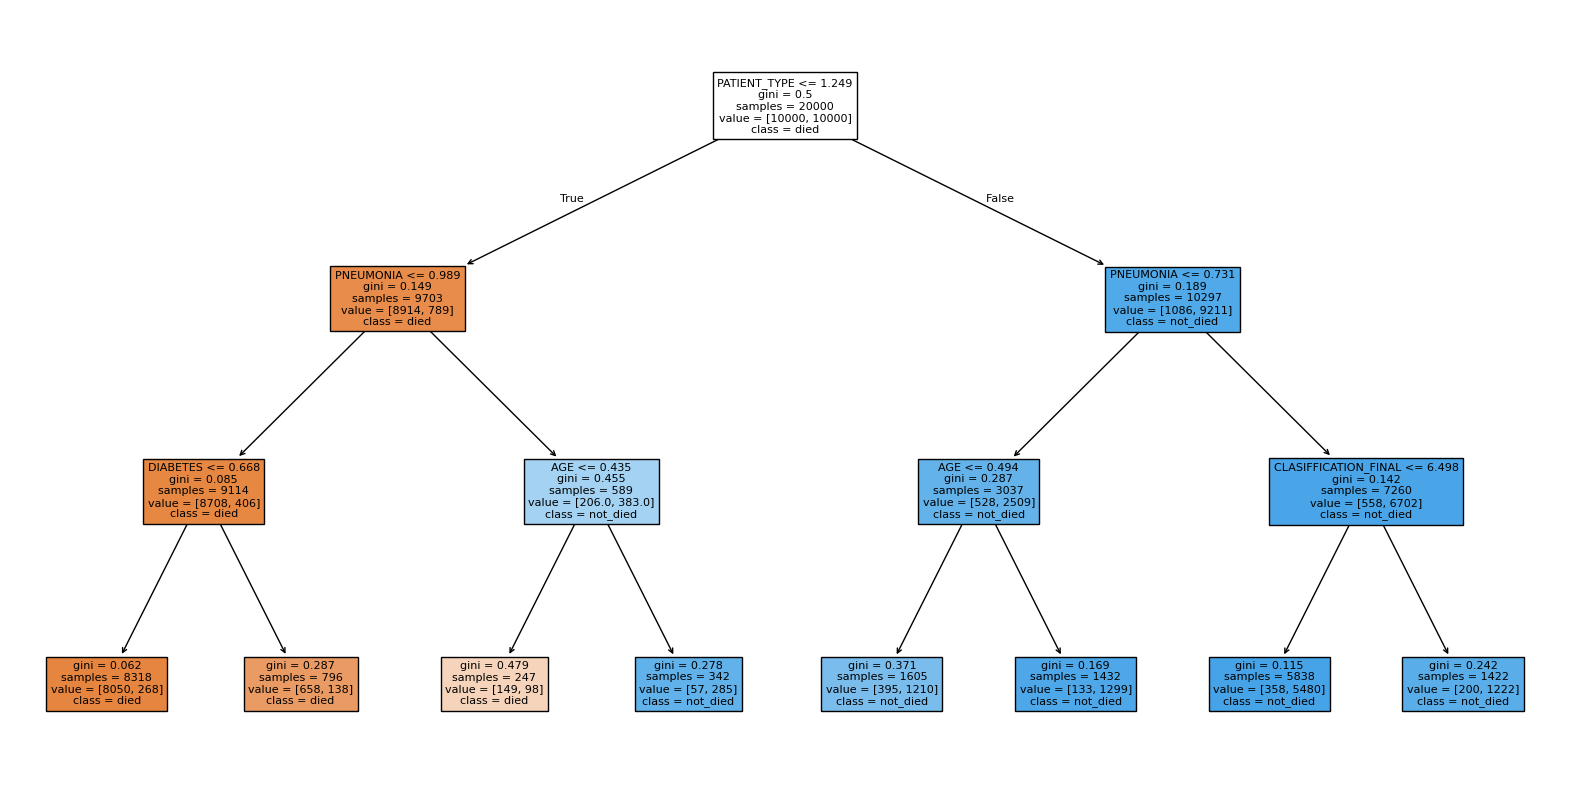

Klassifikator: DecisionTreeClassifier 3 gini random

Accuracy: 0.91695
F1: 0.9198320382257831
Precision: 0.8889821811736169
Recall: 0.9529
MCC: 0.8360638622561493

Klassifikator: DecisionTreeClassifier 5 entropy best

Accuracy: 0.91845
F1: 0.9216505740500552
Precision: 0.8868447813626699
Recall: 0.9593
MCC: 0.8397071687204529

Klassifikator: DecisionTreeClassifier 5 entropy random

Accuracy: 0.91575
F1: 0.919227266190499
Precision: 0.882791639812172
Recall: 0.9588
MCC: 0.8345992844773575

Klassifikator: DecisionTreeClassifier 5 gini best

Accuracy: 0.91845
F1: 0.9216505740500552
Precision: 0.8868447813626699
Recall: 0.9593
MCC: 0.8397071687204529

Klassifikator: DecisionTreeClassifier 5 gini random

Accuracy: 0.9161
F1: 0.9197896749521989
Precision: 0.881043956043956
Recall: 0.9621
MCC: 0.8357443861003161

Klassifikator: DecisionTreeClassifier 7 entropy best

Accuracy: 0.91625
F1: 0.9195446467169412
Precision: 0.8847398095942324
Recall: 0.9572
MCC: 0.8353061675883581

Klassifikator: De

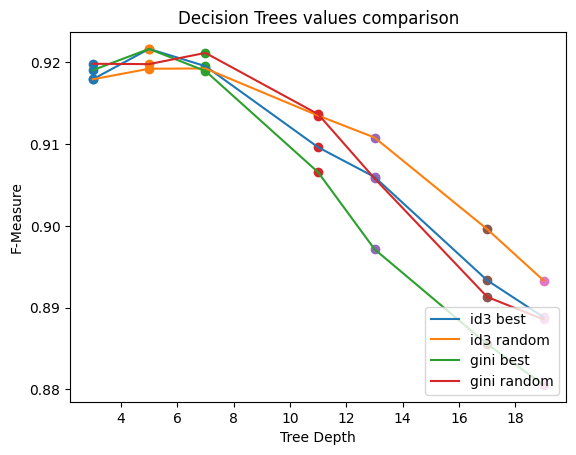

In [41]:
#Wir wenden nun den Entscheidungsbaum-Klassifikator an und untersuchen dabei die Kombination verschiedener Hyperparameter.
#Insbesondere vergleichen wir als Auswahlmetrik die Gini Impurity mit der beim Iterativen Dichotomiser 3 (einem TDIDT-Verfahren;
#siehe Modul "Einführung in das Maschinelle Lernen") verwendete (Shannon-)Entropie; wir vergleichen eine zufällige Auswahl
#des jeweiligen Schwellwertes mit einer Auswahl der (jeweils) besten Schwellwertes; und wir vergleichen verschiedene Baumtiefen
#von 3-19 miteinander. 

#Alle berechneten Bäume der Tiefe 3 werden als Grafik dargestellt. Zusätzlich werden die f1-Werte der verschiedenen
#Hyperparameter-Kombinationen in Abhängigkeit von der Baumtiefe in einem Diagramm verglichen.

heuristics = ["entropy", "gini"]
splitters = ["best", "random"]
max_depth = [3, 5, 7, 11, 13, 17, 19]
dt_fmeasures = {}
dt_best_result = 0
dt_best = None

for d in max_depth:
    dt_fmeasures[d] = np.zeros(len(heuristics)*len(splitters))
    i=0
    for heuristic, splitter in [(heuristic, splitter) for heuristic in heuristics for splitter in splitters]:     
        clf = DecisionTreeClassifier(criterion=heuristic, splitter=splitter, max_depth=d, class_weight='balanced')
        acc, f1, prec, rec, mcc = apply_classifier(train_x, train_y, clf, True, str(d), heuristic, splitter)
        dt_fmeasures[d][i] = f1
        i=i+1

        if f1 > dt_best_result:
            dt_best_result = f1
            dt_best = clf

            
l1, l2, l3, l4 = [], [], [], []
for k in dt_fmeasures.keys():
    fmeasures = dt_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(dt_fmeasures[k][0])
    l2.append(dt_fmeasures[k][1])
    l3.append(dt_fmeasures[k][2])
    l4.append(dt_fmeasures[k][3])
    

plt.errorbar(max_depth, l1, label ='id3 best')
plt.errorbar(max_depth, l2, label ='id3 random')
plt.errorbar(max_depth, l3, label ='gini best')
plt.errorbar(max_depth, l4, label ='gini random')

plt.legend(loc ='lower right')
plt.title('Decision Trees values comparison')
plt.xlabel('Tree Depth')
plt.ylabel('F-Measure')
plt.show()



Anwendung von ML-Verfahren: Random Forest

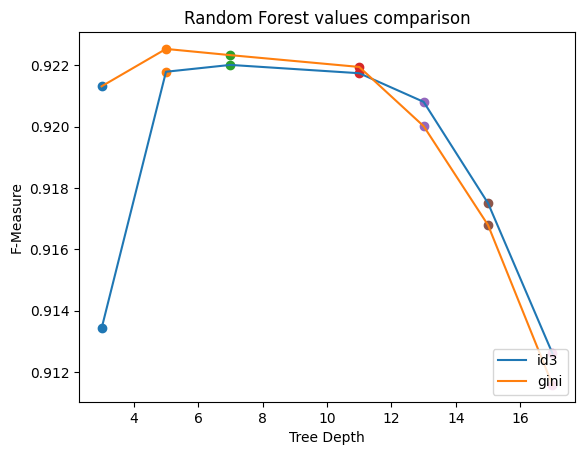

In [30]:
#Wir wenden nun den Random-Forest-Klassifikator an. Dieser besteht aus einzelnen Entscheidungsbäumen, deren Voten durch 
#eine modifizierte Variante des aggregierten Bootstrapping (Bagging) zusammengefasst werden. Dementsprechend vergleichen
#wir auch hier wieder die beiden oben genannten Auswahlmetriken und verschiedene Baumtiefen miteinander. 
#Die f1-Werte für die verschiedenen Baumtiefen sind wiederum in einem Diagramm dargestellt. 

heuristics = ["entropy", "gini"]
max_depth = [3, 5, 7, 11, 13, 15, 17]
rf_fmeasures = {}
rf_best_result = 0

for j in range(5):
    for d in max_depth:
        rf_fmeasures[d] = np.zeros(len(heuristics))
        for (i, heuristic) in enumerate(heuristics):
            clf = RandomForestClassifier(n_estimators=100, criterion=heuristic, max_depth=d, class_weight='balanced')
            acc, f1, prec, rec, mcc = apply_classifier(train_x, train_y, clf, True, str(d), heuristic)
            rf_fmeasures[d][i] = f1
            
            if rf_fmeasures[d][i] > rf_best_result:
                rf_best_result = rf_fmeasures[d][i]
                rf_best_model = clf   
     


l1, l2 = [], []
for k in rf_fmeasures.keys():
    fmeasures = rf_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(rf_fmeasures[k][0])
    l2.append(rf_fmeasures[k][1])


plt.errorbar(max_depth, l1, label ='id3')
plt.errorbar(max_depth, l2, label ='gini')
plt.legend(loc ='lower right')
plt.title('Random Forest values comparison')
plt.xlabel('Tree Depth')
plt.ylabel('F-Measure')
plt.show()

Anwendung eines Deep-Learning-Verfahren: Multi-Layer-Perzeptron (MLP)

Best Validation Loss: 0.2355
Best Validation Accuracy: 0.9184
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
Klassifikator: Sequential

Accuracy: 0.91775
F1: 0.9208792265884277
Precision: 0.8871281623575201
Recall: 0.9573
MCC: 0.8381261121365741



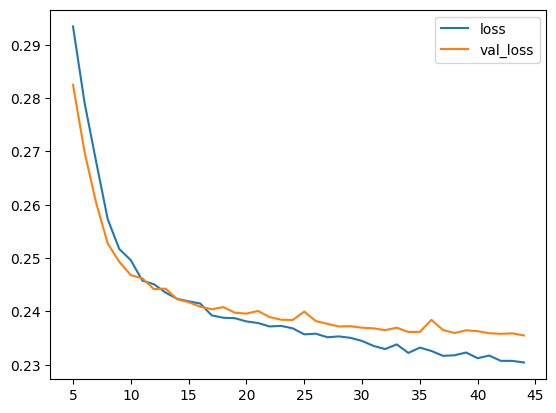

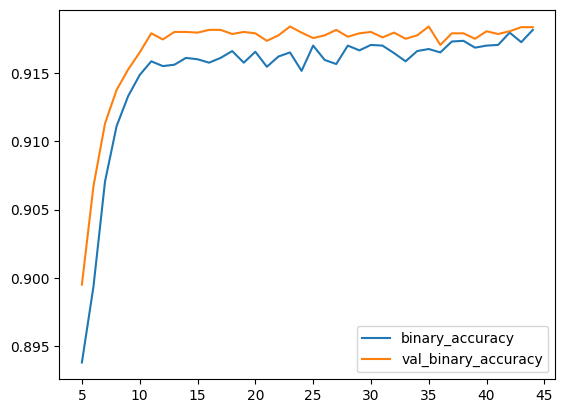

In [40]:
#Als Deep-Learning-Ansatz verwenden wir zunächst ein einfaches Multi-Layer-Perzeptron mit zwei verdeckten Schichten und 
#jeweils 8 Neuronen. Ein Dropout-Layer setzt bei jedem Trainingsschritt einen Eingang der zweiten verdeckten Schicht
#in einem von Hundert Fällen auf 0, um ein besseres Generalisierungsverhalten zu ermöglichen. 

model = keras.Sequential([
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.01),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid')])

#Als Optimierungsalgorithmus wird ein Adaptiver Momentenschätzer (Adam; eine Variante des stochastischen Gradientenabstiegs)
#und als Verlustfunktion die Binäre Kreuzentropie gewählt. Beides sind für unseren Anwendungsfall geeignete
#Standardeinstellungen.  

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

#Ein frühes Stoppen beendet das Training des Netzes, wenn keine weitere Verbesserung zu erwarten ist. 
    
early_stopping = keras.callbacks.EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)

#In diesem Schritt geschieht das eigentliche Training des Netzes. Die Batch-Größe ist hier mit 128 relativ 
#klein gewählt. 

history = model.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=128, epochs=1000, 
                    callbacks=[early_stopping], verbose=0)

#Trainings- und Validierungsverlust werden in Abhängigkeit vom Trainingsschritt geplottet, um das Lernverhalten
#analysieren zu können sowie ein potentielles Over- bzw. Underfitting zu erkennen. 
#Auch die binäre Accuracy des Trainings- und des Validierungsets werden zusammen geplottet, um das Lernverhalten 
#des Netzes einschätzen zu können. 

history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" + "\nBest Validation Accuracy: {:0.4f}").format(history_df['val_loss'].min(),
                  history_df['val_binary_accuracy'].max()))

#Schließlich werden die Evaluationsmetriken des trainierten Modells geplottet. Zu beachten ist, dass Test- und 
#Validierungset hier übereinstimmen. Bei einer weitergehenden Analyse müsste ein eigenständiges Testset verwendet
#werden.

y_pred = (model.predict(test_x) > 0.5).astype("int32")
acc, f1, prec, rec, mcc = get_scores(test_y, y_pred)
print_measures(model, acc, f1, prec, rec, mcc)